# 11_1 In class example, Regression with Random Forest
We will load auto mpg dataset and figure out what is the most important predictor(s) for mpg. And then see what happens to mpg when these predictors are permuted.

Note:  Any data gleaned from this sort of thing is only as good as your model.  So if your model is very bad at making predictions then it's notions about what are the most important predictors are also very bad!

See <a href="https://archive.ics.uci.edu/ml/datasets/Auto+MPG">this</a> page for original data

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

# Load Data

In [32]:
#want to see it all in a dataframe?

df = pd.read_fwf("../datasets/autompg/auto-mpg.data", names=['mpg','cylinders','displacement','horsepower','weight','acceleration','model year','origin','car name' ],header=None)
# df = pd.DataFrame(data= np.c_[data['data']],
#                      columns= data['feature_names'])
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,"""chevrolet chevelle malibu"""
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,"""buick skylark 320"""
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,"""plymouth satellite"""
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,"""amc rebel sst"""
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,"""ford torino"""


In [33]:
#dump car name as it has no information
df=df.drop(columns=['car name'])

In [34]:
#there are no nulls
%time
df.isnull().sum().sum()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


0

In [35]:
df.dtypes

#get rid of missing horsepower rows
df=df[df.horsepower!='?']

In [36]:
#convert horsepower
df.horsepower=df.horsepower.map(lambda x: float(x))

# Split out target

In [37]:
y=df.mpg
df.drop(columns=['mpg'], inplace=True)

## Any correlations?  If so dump em
Correlations interfere with calculating importance.  For instance, if you have 2 highly correlated columns; A and B.  If you scramble A then B still has As information.  This will result in a lower importance value for both features, where they might actually be important.

In [38]:
# fig, ax = plt.subplots(figsize=(15, 15))
corr = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

#BTW how do you choose a threshold here? If you vary this from .98 to .65 you will see a decrease and then increase in model accuracy.
# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.92)]
print(f'Dropping {to_drop}')
df=df.drop(columns=to_drop)

Dropping ['displacement', 'weight']


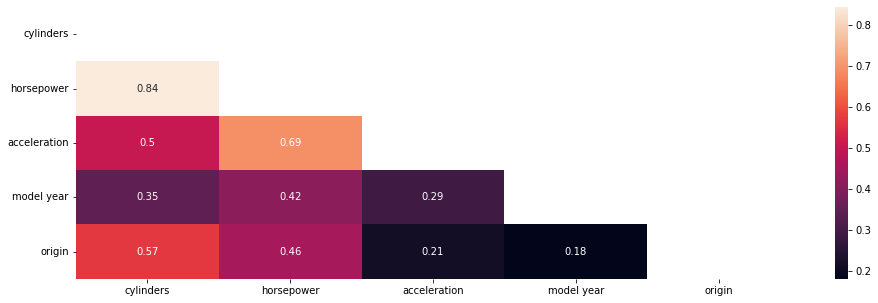

In [39]:
#make the heatmap fit on the screen
plt.figure(figsize=(16, 5))

# generate the correlation matrix (abs converts to absolute value, this way we only look for 1 color range)
corr = df.corr().abs()

# Generate mask for the upper triangle (see https://seaborn.pydata.org/examples/many_pairwise_correlations.html)
# the matrix is symmetric, the diagonal (all 1's) and upper triangle are visual noise, use this to mask both out
mask = np.tril(np.ones_like(corr, dtype=bool), k=-1)    #k=-1 means get rid of the diagonal

corr = corr.where(cond=mask)

sns.heatmap(corr, annot=True);

# Train a model

In [40]:
#get train test split
X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=42)

In [41]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
print("F^2 on test data: {:.2f}".format(clf.score(X_test, y_test)))

F^2 on test data: 0.84


# Permutation importance

In [42]:
from sklearn.inspection import permutation_importance

In [44]:
%%time
result = permutation_importance(
    clf, X_test, y_test, n_repeats=10, random_state=42)
forest_importances = pd.Series(result.importances_mean, index=X_test.columns)

CPU times: user 363 ms, sys: 0 ns, total: 363 ms
Wall time: 361 ms


In [12]:
# fig, ax = plt.subplots(figsize=(10,7))
# forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
# ax.set_title("Random Forest feature importance via permutation importance")
# ax.set_ylabel("Mean accuracy decrease")
# fig.tight_layout()
# plt.show()

In [45]:
forest_importances.index
forest_importances
# forest_importances['mean radius']

cylinders       0.513499
horsepower      0.349665
acceleration    0.041145
model year      0.346034
origin          0.014616
dtype: float64

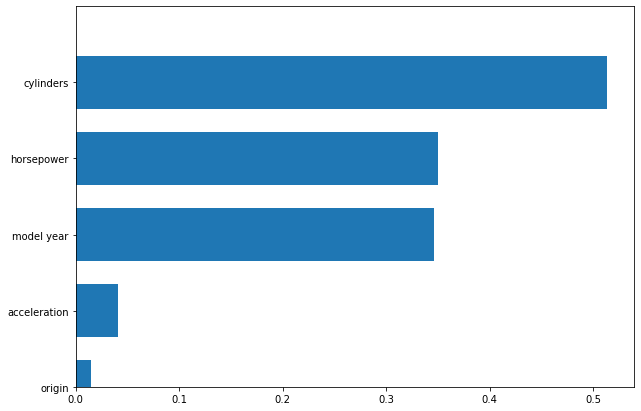

In [46]:
#plot em
forest_importances = forest_importances.sort_values(ascending=True)
tree_indices = forest_importances.index

fig, ax = plt.subplots(figsize=(10,7))
_=ax.barh(tree_indices, forest_importances, height=0.7)
_=ax.set_yticks(tree_indices)
_=ax.set_yticklabels(tree_indices)
_=ax.set_ylim((0, len(tree_indices)))


# It looks like 'cylenders' and 'Horsepower' matter quite a bit.  What happens if it's permuted?

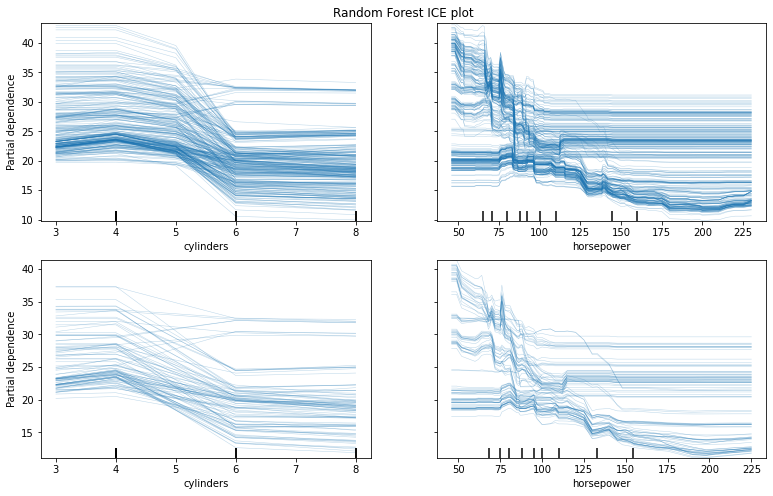

In [47]:

fig, (ax,ax1) = plt.subplots(2,1,figsize=(13, 8))
ax.set_title("Random Forest ICE plot")
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(clf, X_train, features=[0,1],kind='individual', ax=ax)
PartialDependenceDisplay.from_estimator(clf, X_test, features=[0,1],kind='individual', ax=ax1)

# And the PDP

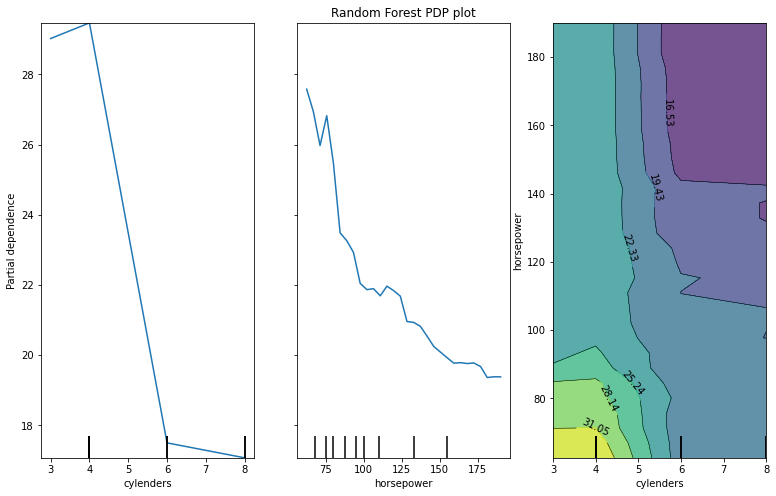

In [48]:
from sklearn.inspection import PartialDependenceDisplay
fig, ax = plt.subplots(figsize=(13, 8))
ax.set_title("Random Forest PDP plot")
my_plots = PartialDependenceDisplay.from_estimator(clf, 
                                   features=[0,1,(0,1)], 
                                   X=X_test, 
                                   feature_names=['cylenders','horsepower'], 
                                   grid_resolution=30, ax=ax)